# **Tell Me What You Want, I'll Tell You What You Like**

In this file, we try to use a better clustering approach (exploration then exploitation)

## DOcplex Python API installation

First, we install the docplex python API which we will use for modelling our problem and solving it. (Then, we will not have problem size error)

In [1]:
import sys
try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        !pip install docplex -q
        print("!pip install docplex -q...")
    else:
        !pip install --user docplex -q
        print("!pip install --user docplex -q...")
        
print("End of the intallation of python API...")

End of the intallation of python API...


## Main code

In [2]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time

In [3]:
#############################
### Essentials functions ###
#############################
import FunctionMain as fm
import clustering as cl
import my_clustering as my_cl

In [4]:
# ----------------- Parameters

# The file to consider
file = './file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 10

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 1000

# Number of iteration stop criterion
it_max = 30




# The number of solutions that we will have in the solver after the first iteration
k_k = 15

list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, starts = fm.initialize_solver(data, n, m, duration)

model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)


# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model
variables = solver.get_variables()

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 2253818
Le max de list_obj est 3701628
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[], [], [], [], []]


In [5]:
####################################################################
#### Exploration: RECHERCHE DE NOUVELLES SOLUTIONS 
####################################################################

import clustering as cl

###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj = [min(list_obj)]
list_min_obj_global = [min(list_obj)]
it_max_exploration = 0.75*it_max
tps_max_exploration = 0.75*tps_max
criterion = (tps < tps_max_exploration) and (it < it_max_exploration) 

# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))
    it += 1

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, starts = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # # --------- Add the constraints considering the clustering
    
    list_rayon_layers, list_start_sol_layers, dict_sol_rayon  = my_cl.list_rayon_binaire_cluster(n, m, list_layers)
    list_rayon_layers_flatten = [item for sublist in list_rayon_layers[1:] for item in sublist]
    list_start_sol_layers_flatten = [item for sublist in list_start_sol_layers[1:] for item in sublist]
         
    for l in range(len(list_rayon_layers_flatten)):
        solver.add_constraint(model, my_cl.manhattan_binaire_distance_contrainte(list_start_sol_layers_flatten[l], [model.start_of(variables[i//m][i%m]) for i in range(n*m)]) > list_rayon_layers_flatten[l])
               
            
    # --------- Add the constraints considering the clustering
    model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

    # ------------ Solve the model
    print("\nSolving the model...")
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max_exploration) and (it < it_max_exploration) 
    fm.stopCondition(it, it_max_exploration, tps, tps_max_exploration)


--------Iteration 1---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...
The number of solutions generated is : 5012
Objective function : [2253818, 2287562]
Model solved !

Classing solutions...
Le min de list_obj est 2253818
Le max de list_obj est 3701628
Solutions classed !

Creating preferences...
Preferences created !
Il y a 30 solution(s)
Objective function global : [2253818, 2253818]

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes

--------Iteration 2---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraint

[2253818, 2287562, 2220240, 2404500, 2336320, 2501168, 2282196, 2202144, 2319916, 2283344, 2313690, 2253648, 2336320, 2256432, 2260608, 2263392, 2279126, 2297404, 2249472, 2294592, 2266472, 2239758, 2479500]


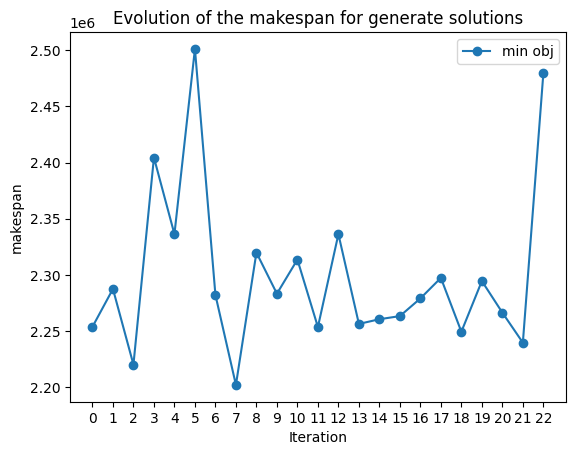

In [6]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[2253818, 2253818, 2220240, 2220240, 2220240, 2220240, 2220240, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144]


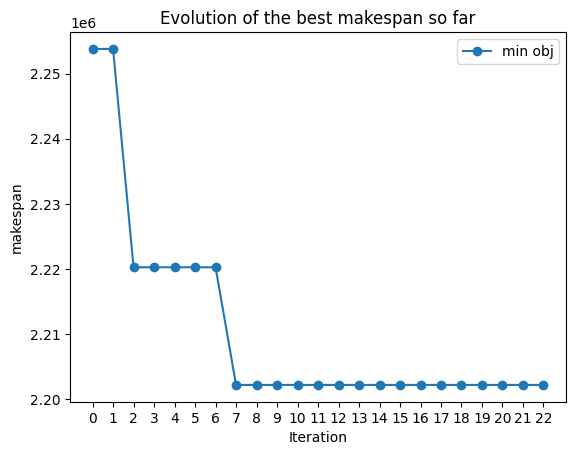

In [7]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

In [8]:
####################################################################
#### Exploitation: RECHERCHE DE NOUVELLES SOLUTIONS 
####################################################################

import clustering as cl

###  -------------- Iteration of the solver with the preferences
k_k = 4

criterion = (tps < tps_max) and (it < it_max) 
# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))
    it += 1

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, starts = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # # --------- Add the constraints considering the clustering
    
    list_rayon_layers, list_start_sol_layers, dict_sol_rayon  = my_cl.list_rayon_binaire_cluster(n, m, list_layers)
    
    list_cluster_layers = my_cl.my_clustering_binaire(n, m, list_rayon_layers, list_layers)

    list_centroides_layers = my_cl.centroides_clusters(n, m, list_cluster_layers)

    sum = 0
    for i in range(len(list_centroides_layers)): #On parcourt les layers
        sum_temp = 0
        for j in range(len(list_centroides_layers[i])): #On parcourt les clusters
            sum_temp += my_cl.manhattan_binaire_distance_contrainte(list_centroides_layers[i][j], [model.start_of(variables[i//m][i%m]) for i in range(n*m)])
        sum_temp *= len(list_centroides_layers)-i 
    sum += sum_temp
    model.add(minimize(sum))

   

    # ------------ Solve the model
    print("\nSolving the model...")
    # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, T_machine, optimalval, tps_max, it_max)
    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)+user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max) 
    fm.stopCondition(it, it_max, tps, tps_max)



--------Iteration 23---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Solving the model...


TypeError: Solver.solve() takes 6 positional arguments but 9 were given

In [ ]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

In [ ]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

In [ ]:
# print(len(list_layers)) #nb layer
# print(len(list_cluster_layers[0])) #nb cluster du layer 0
# print(len(list_cluster_layers[0][0])) #nb sol du cluster 0 du layer 0

# list_layers #nb layer
# print(len(list_layers[0])) #nb cluster du layer 0

# n=0
# sol_per_layer = []

# for i in range(len(list_cluster_layers)):
#     nb=0
#     for j in range(len(list_cluster_layers[i])):
        
#         for k in range(len(list_cluster_layers[i][j])):
#             n+=1
#             nb+=1
#     sol_per_layer.append(nb)
# print(n)

# m=0
# sol_per_layer2 = []
# for i in range(len(list_layers)):
#     sol_per_layer2.append(len(list_layers[i]))
#     for j in range(len(list_layers[i])):
#         m+=1


# p=0
# sol_per_layer3 = []
# for i in range(len(list_rayon_layers)):
#     sol_per_layer3.append(len(list_rayon_layers[i]))
#     for j in range(len(list_rayon_layers[i])):
#         p+=1
# print(n)
# print(p)
# print(m)
# print(sol_per_layer)
# print(sol_per_layer2)
# print(sol_per_layer3)

In [ ]:
# #flatten list_cluster_layers[0]
# list_cluster_layers_flatten = []
# for i in range(len(list_cluster_layers[0])):
#     list_cluster_layers_flatten = list_cluster_layers_flatten + list_cluster_layers[0][i]
# #vérifier si les solutions sont bien différentes
# for i in range(len(list_cluster_layers_flatten)):
#     for j in range(len(list_cluster_layers_flatten)):
#         if i!=j:
#             if (list_cluster_layers_flatten[i] == list_cluster_layers_flatten[j]):
#                 print("erreur")
#                 print(i)
#                 print(j)
        